<a href="https://www.kaggle.com/code/proxzima/skin-cancer-mnist-resnet50-iv3-vgg16-19-googlenet?scriptVersionId=105335083" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div align="center">
<font size="6"> Skin Cancer MNIST Classification (ResNet50, InceptionV3, VGG16, VGG19, GoogLeNet)  </font>  
</div> 

# 1. Convolutional Neural Network

<div align="center">
<font size="4"> Residual learning: a building block.  </font>  
</div> 

<img align="left" src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/A-cell-from-the-Residual-Network-architecture-The-identity-connection-helps-to-reduce.png" data-canonical-src="https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/A-cell-from-the-Residual-Network-architecture-The-identity-connection-helps-to-reduce.png" width="350" height="350" style='margin-right:10px'/>
The degradation (of training accuracy) indicates that not all systems are similarly easy to optimize. In [Kaiming He et all. 2015] the degradation problem is adressed by introducing a deep residual learning framework. Instead of hoping each few stacked layers directly fit a desired underlying mapping, we explicitly let these layers fit a residual mapping. Formally, denoting the desired underlying mapping as H(x), we let the stacked nonlinear layers fit another mapping of F(x) := H(x)−x. The original mapping is recast into F(x)+x. We hypothesize that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers. 

The formulation of F(x)+x can be realized by feedforward neural networks with ''shortcut connections'' (see scheme). Shortcut connections are those skipping one or
more layers. In our case, the shortcut connections simply perform identity mapping, and their outputs are added to the outputs of the stacked layers (see scheme). Identity shortcut connections add neither extra parameter nor computational complexity. The entire network can still be trained end-to-end by SGD with backpropagation, and can be easily implemented using common libraries

&nbsp;
&nbsp;

<div align="center">
<font size="4"> Example of ResNet50 vs Xception vs Inception-V3 vs VGG-19 vs VGG-16 as reference model.  </font>  
<img align="center" src="https://www.researchgate.net/profile/Tiago-Carvalho-8/publication/330478807/figure/fig1/AS:756995804110849@1557493272678/VGG16-VGG19-Inception-V3-Xception-and-ResNet-50-architectures.ppm" data-canonical-src="https://www.researchgate.net/profile/Tiago-Carvalho-8/publication/330478807/figure/fig1/AS:756995804110849@1557493272678/VGG16-VGG19-Inception-V3-Xception-and-ResNet-50-architectures.ppm" width="870" />
</div>

&nbsp;
&nbsp;

<div align="center">
<font size="4"> Detailed example of GoogLeNet a.k.a. Inception-V1 (Szegedy, 2015) as reference model.  </font>  
<img align="center" src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/googlenet.png" data-canonical-src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/googlenet.png" />
</div> 

# 2. Libraries

# 2.1 Load Required Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import re
import gc
import sys
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from glob import glob

import cv2

import PIL
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)

# 2.2 Load TensorFlow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, Dropout, BatchNormalization,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
from keras.layers.merge import concatenate

from tensorflow.python.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

tf.get_logger().setLevel('ERROR')

# 3. Configs

In [3]:
CFG = dict(
    batch_size            =  20,   # 8; 16; 32; 64; bigger batch size => moemry allocation issue
    epochs                =  30,   # 5; 10; 20;
    last_trainable_layers =   0,
    verbose               =   1,   # 0; 1
    fontsize              =  14,

    # Images sizes
    img_width             = 150,   # 600 Original
    img_height            = 112,   # 450 Original

    # Images augs
    ROTATION_RANGE        =  90.0,
    ZOOM_RANGE            =   0.1,
    HSHIFT_RANGE          =   0.1,
    WSHIFT_RANGE          =   0.1,
    HFLIP                 = False,
    VFLIP                 = False,

    # Postprocessing
    stopper_patience      =  10,   # 0.01; 0.05; 0.1; 0.2;
    run_functions_eagerly = True
)

# 4. Paths

In [4]:
base_skin_dir = os.path.join('..', 'input')
#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}

# 5. Dataset
# 5.1 Description

The data set contains the following diseases:  
- Actinic Keratosis
- Basal Cell Carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented Benign Keratosis
- Vascular Lesion

In [5]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
# df = pd.read_pickle(f"../input/skin-cancer-mnist-ham10000-pickle/HAM10000_metadata-h{CFG['img_height']}-w{CFG['img_width']}.pkl")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
# Given lesion types
classes = df.dx.unique()
num_classes = len(classes)
classes, num_classes

(array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object), 7)

In [7]:
#Lesion Dictionary created for ease
lesion_type_dict = {
    'bkl'  : 'Pigmented Benign keratosis',
    'nv'   : 'Melanocytic nevi', # nevus
    'df'   : 'Dermatofibroma',
    'mel'  : 'Melanoma',
    'vasc' : 'Vascular lesions',
    'bcc'  : 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
}

In [8]:
# Not required for pickled data
# Creating New Columns for better readability

df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")
df['path'] = df.image_id.map(imageid_path_dict.get)
df['cell_type'] = df.dx.map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df.dx).codes
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,num_images,path,cell_type,cell_type_idx
9725,HAM_0004376,ISIC_0024843,akiec,histo,70.0,female,face,1,../input/skin-cancer-mnist-ham10000/ham10000_i...,Actinic keratoses,0
6059,HAM_0003024,ISIC_0024768,nv,follow_up,35.0,female,trunk,1,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,5
4540,HAM_0001659,ISIC_0026564,nv,follow_up,35.0,male,lower extremity,1,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,5
3817,HAM_0004625,ISIC_0029346,nv,follow_up,40.0,male,upper extremity,1,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,5
7914,HAM_0000443,ISIC_0034271,nv,histo,35.0,female,back,1,../input/skin-cancer-mnist-ham10000/ham10000_i...,Melanocytic nevi,5


# 5.2 Exploratory Data Analysis

In [9]:
df.shape

(10015, 11)

In [10]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
num_images        0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [11]:
df.age.fillna((df.age.mean()), inplace=True)
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
num_images       0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

# 6. Keras image data processing

In [12]:
# Not required for pickled data
df['image'] = df.path.map(lambda x: np.asarray(Image.open(x).resize((CFG['img_width'], CFG['img_height']))))
df.to_pickle(f"HAM10000_metadata-h{CFG['img_height']}-w{CFG['img_width']}.pkl", compression='infer', protocol=4)

In [13]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,num_images,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,../input/skin-cancer-mnist-ham10000/ham10000_i...,Pigmented Benign keratosis,2,"[[[188, 151, 193], [193, 156, 198], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,../input/skin-cancer-mnist-ham10000/ham10000_i...,Pigmented Benign keratosis,2,"[[[24, 13, 22], [24, 13, 22], [24, 14, 25], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,../input/skin-cancer-mnist-ham10000/ham10000_i...,Pigmented Benign keratosis,2,"[[[186, 126, 135], [189, 131, 142], [192, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,../input/skin-cancer-mnist-ham10000/ham10000_i...,Pigmented Benign keratosis,2,"[[[23, 11, 16], [24, 11, 19], [26, 13, 22], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,../input/skin-cancer-mnist-ham10000/ham10000_i...,Pigmented Benign keratosis,2,"[[[129, 87, 109], [139, 94, 117], [148, 102, 1..."


In [14]:
def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images

df_single = df[df.num_images == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 80)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 600)
trainset3 = df[df.num_images != 1]
trainset = pd.concat([trainset2, trainset3])

trainimages = prepareimages(list(trainset.image))
testimages = prepareimages(list(testset.image))
validationimages = prepareimages(list(validationset.image))
trainlabels = np.asarray(trainset.cell_type_idx)
testlabels = np.asarray(testset.cell_type_idx)
validationlabels = np.asarray(validationset.cell_type_idx)

In [15]:
image_shape = (CFG['img_height'], CFG['img_width'], 3)

trainimages = trainimages.reshape(trainimages.shape[0], *image_shape)

data_gen = ImageDataGenerator(
    rotation_range = CFG['ROTATION_RANGE'],    # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = CFG['ZOOM_RANGE'],            # Randomly zoom image 
    width_shift_range = CFG['WSHIFT_RANGE'],   # randomly shift images horizontally
    height_shift_range = CFG['HSHIFT_RANGE'],  # randomly shift images vertically
    horizontal_flip=CFG['HFLIP'],              # randomly flip images
    vertical_flip=CFG['VFLIP']                 # randomly flip images
)
data_gen.fit(trainimages)

# 7. Model

# 7.1 Build the model

In [16]:
def build_model(
    base_model,
    base_model_name,
    model_optimizer,
    raw_model = False,
    last_trainable_layers = CFG['last_trainable_layers'],
    model_loss = 'sparse_categorical_crossentropy'
):
    print(f'Building {base_model_name} model...')

    # We reduce significantly number of trainable parameters by freezing certain layers,
    # excluding from training, i.e. their weights will never be updated
    for layer in base_model.layers:
        layer.trainable = False

    if 0 < last_trainable_layers < len(base_model.layers):
        for layer in base_model.layers[-last_trainable_layers:]:
            layer.trainable = True

    if raw_model == True:
        model = base_model
    else:
        model = Sequential([
            base_model,

            Dropout(0.5),
            Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.02)),

            Dropout(0.5),
            Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.02)) # num classes = 9
        ])

    model.compile(
        optimizer = model_optimizer,
      # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
        loss = model_loss,
        metrics=['accuracy']
    )
    
    return model

# 7.2 Visualize model

In [17]:
def visualize_model(model, model_name):
    print(model.summary())
    return plot_model(model, to_file=f'{model_name}_plot.png', show_shapes=True, show_layer_names=True)

# 8. Fit model

In [18]:
class GCCollectCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [19]:
def fit_model(
    model,
    model_name,
    trainimages,
    trainlabels,
    validationimages,
    validationlabels,
    early_stopper_patience = CFG['stopper_patience'],
    epochs = CFG['epochs'],
    batch_size = CFG['batch_size']
):
    # tf.function - decorated function tried to create variables on non-first call'. 
    tf.config.run_functions_eagerly(CFG['run_functions_eagerly']) # otherwise error

    print(f'Fitting {model_name} model...')
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = early_stopper_patience)
    cb_checkpointer  = ModelCheckpoint(
        filepath=f'model/{model_name}.hdf5',
      # filepath = CFG['path_model']+'ResNet50-{epoch:02d}-{val_loss:.2f}.hdf5',
        monitor  = 'val_loss',
        save_best_only=True, 
        mode='min'
    )

    callbacks_list = [cb_checkpointer, cb_early_stopper]

    history = model.fit(
        data_gen.flow(trainimages, trainlabels, batch_size = batch_size),
        epochs = epochs,
        validation_data = data_gen.flow(validationimages, validationlabels, batch_size = batch_size),
        verbose = CFG['verbose'],
        steps_per_epoch=trainimages.shape[0] // batch_size,                   
        callbacks=[cb_checkpointer, cb_early_stopper] # We can add GCCollectCallback() to save memory
    )

    return history

# 9. Visualize performance

In [20]:
def visualize_performance(model_name, history, fontsize = CFG['fontsize']):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    metrics = history.history['accuracy']
    epochs_range = range(1, len(metrics) + 1) 

    plt.figure(figsize=(23, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.suptitle(f'Accuracy & Loss for {model_name} model', fontsize=fontsize)
    plt.show()

# 10. Evaluate on test

In [21]:
def evaluate_model(
    model_name,
    trainimages,
    trainlabels,
    validationimages,
    validationlabels,
    testimages,
    testlabels
):
    print(f'Evaluating {model_name} model...\n')
    model = load_model(f'./model/{model_name}.hdf5') # Loads the best fit model

    print("\nTrain accuracy = {}  ;  Train loss = {}\n".format(*model.evaluate(trainimages, trainlabels, verbose = CFG['verbose'])))

    print("Validation accuracy = {}  ;  Validation loss = {}\n".format(*model.evaluate(validationimages, validationlabels, verbose = CFG['verbose'])))

    test_loss, test_acc = model.evaluate(testimages, testlabels, verbose = CFG['verbose'])
    print(f"Test accuracy = {test_acc}  ;  Test loss = {test_loss}")

    return (model, test_loss, test_acc)

In [22]:
def computing_prediction(model, model_name, trainimages, testimages):
    print(f'Computing predictions for {model_name}...')
    train_pred = model.predict(trainimages)
    train_pred_classes = np.argmax(train_pred,axis = 1)
    test_pred = model.predict(testimages)
    # Convert predictions classes to one hot vectors
    test_pred_classes = np.argmax(test_pred,axis = 1)

    return train_pred, train_pred_classes, test_pred, test_pred_classes

# 11. Compare test_pred with Ground Truth (train_pred)

In [23]:
def model_report(
    model_name,
    trainlabels,
    train_pred_classes,
    testlabels,
    test_pred_classes,
    lesion_type_dict,
    fontsize = CFG['fontsize']
):
    print(f'Model report for {model_name} model ->\n\n')
    print("Train Report :\n", classification_report(trainlabels, train_pred_classes, target_names=lesion_type_dict.values()))
    print("Test Report :\n", classification_report(testlabels, test_pred_classes, target_names=lesion_type_dict.values()))

    cm = confusion_matrix(testlabels, test_pred_classes)

    fig = plt.figure(figsize=(12, 8))
    df_cm = pd.DataFrame(cm, index=lesion_type_dict.values(), columns=lesion_type_dict.values())

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.title(f'Confusion Matrix for Multiclass Classifcation ({model_name})', fontsize=fontsize)
    plt.show()

# 12. ResNet50 model

In [24]:
ResNet50_name = 'ResNet50'

In [25]:
resnet50 = ResNet50(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

Resnet50_model = build_model(
    base_model = resnet50,
    base_model_name = ResNet50_name,
    model_optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
)

94781440/94765736 [==============================] - 1s 0us/step
Building ResNet50 model...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 23,850,887
Trainable params: 263,175
Non-trainable params: 23,587,712
_________________________________________________________________
None


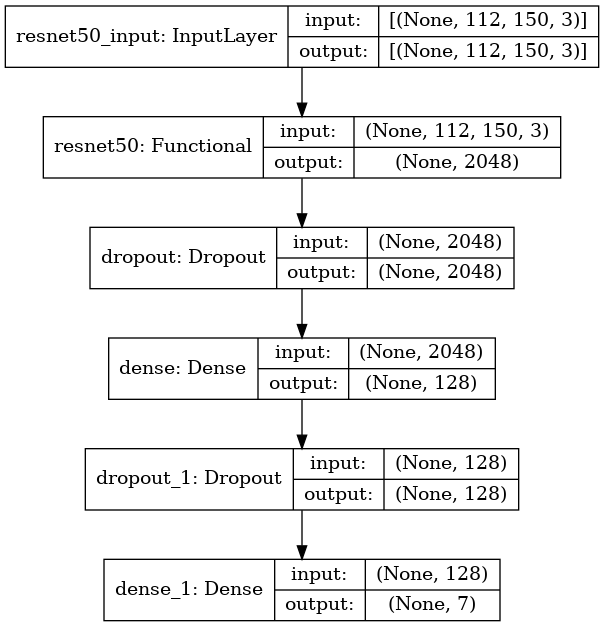

In [26]:
visualize_model(model = Resnet50_model, model_name = ResNet50_name)

In [27]:
history = fit_model(    
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

Fitting ResNet50 model...
Epoch 1/30
401/401 [==============================] - 75s 171ms/step - loss: 5.8916 - accuracy: 0.5580 - val_loss: 4.4813 - val_accuracy: 0.8075
Epoch 2/30
401/401 [==============================] - 68s 168ms/step - loss: 4.2634 - accuracy: 0.6240 - val_loss: 3.4586 - val_accuracy: 0.8279
Epoch 3/30
401/401 [==============================] - 69s 172ms/step - loss: 3.3757 - accuracy: 0.6414 - val_loss: 2.7499 - val_accuracy: 0.8245
Epoch 4/30
401/401 [==============================] - 67s 167ms/step - loss: 2.7749 - accuracy: 0.6609 - val_loss: 2.2441 - val_accuracy: 0.8392
Epoch 5/30
401/401 [==============================] - 67s 166ms/step - loss: 2.3254 - accuracy: 0.6757 - val_loss: 1.8474 - val_accuracy: 0.8324
Epoch 6/30
401/401 [==============================] - 67s 168ms/step - loss: 2.0170 - accuracy: 0.6790 - val_loss: 1.5808 - val_accuracy: 0.8471
Epoch 7/30
401/401 [==============================] - 67s 167ms/step - loss: 1.7818 - accuracy: 0.6854 -

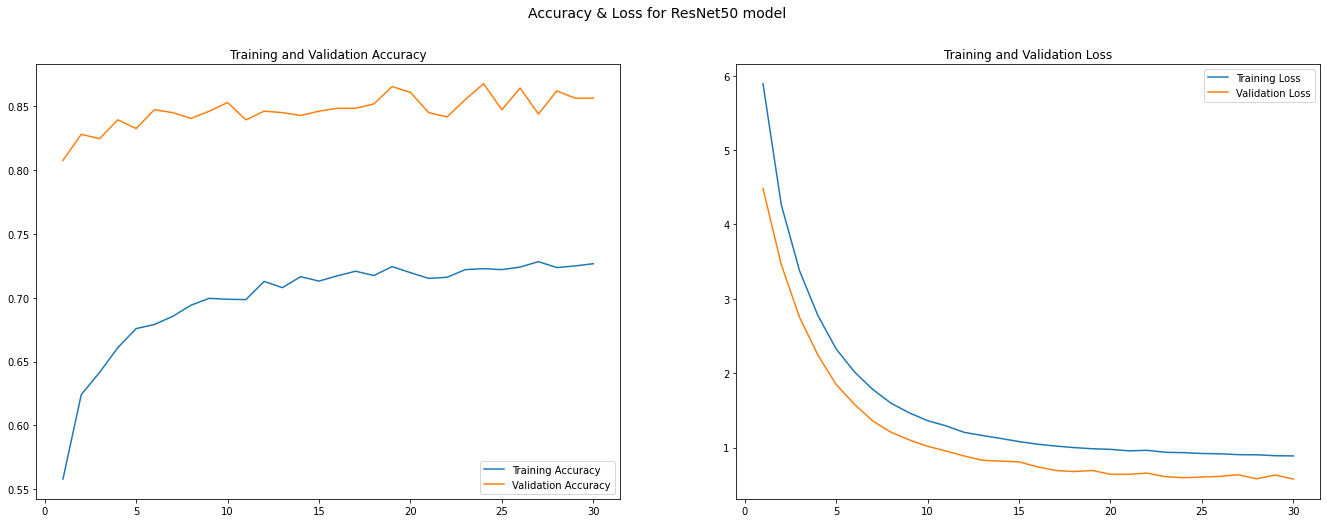

In [28]:
visualize_performance(
    model_name = ResNet50_name,
    history = history
)

In [ ]:
Resnet50_model, test_loss, ResNet50_test_acc = evaluate_model(
    model_name = ResNet50_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = Resnet50_model,
    model_name = ResNet50_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = ResNet50_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 13. InceptionV3 model

In [ ]:
InceptionV3_name = 'InceptionV3'

In [ ]:
inceptionv3 = InceptionV3(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

InceptionV3_model = build_model(
    base_model = inceptionv3,
    base_model_name = InceptionV3_name,
    model_optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
)

In [ ]:
visualize_model(model = InceptionV3_model, model_name = InceptionV3_name)

In [ ]:
history = fit_model(    
    model = InceptionV3_model,
    model_name = InceptionV3_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

In [ ]:
visualize_performance(
    model_name = InceptionV3_name,
    history = history
)

In [ ]:
InceptionV3_model, test_loss, InceptionV3_test_acc = evaluate_model(
    model_name = InceptionV3_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = InceptionV3_model,
    model_name = InceptionV3_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = InceptionV3_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 14. VGG-16 model

In [ ]:
VGG16_name = 'VGG-16'

In [ ]:
vgg16 = VGG16(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

VGG16_model = build_model(
    base_model = vgg16,
    base_model_name = VGG16_name,
    model_optimizer = RMSprop(lr=0.0001, epsilon=None, decay=1e-6)
)

In [ ]:
visualize_model(model = VGG16_model, model_name = VGG16_name)

In [ ]:
history = fit_model(    
    model = VGG16_model,
    model_name = VGG16_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

In [ ]:
visualize_performance(
    model_name = VGG16_name,
    history = history
)

In [ ]:
VGG16_model, test_loss, VGG16_test_acc = evaluate_model(
    model_name = VGG16_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = VGG16_model,
    model_name = VGG16_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = VGG16_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 15. VGG-16 model

In [ ]:
VGG19_name = 'VGG-19'

In [ ]:
vgg19 = VGG19(
    include_top=False,
    input_shape=image_shape,
    pooling = 'avg',
    weights='imagenet'
)

VGG19_model = build_model(
    base_model = vgg19,
    base_model_name = VGG19_name,
    model_optimizer = RMSprop(lr=0.0001, epsilon=None, decay=1e-6)
)

In [ ]:
visualize_model(model = VGG19_model, model_name = VGG19_name)

In [ ]:
history = fit_model(    
    model = VGG19_model,
    model_name = VGG19_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

In [ ]:
visualize_performance(
    model_name = VGG19_name,
    history = history
)

In [ ]:
VGG19_model, test_loss, VGG19_test_acc = evaluate_model(
    model_name = VGG19_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = VGG19_model,
    model_name = VGG19_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = VGG19_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 16. GoogLeNet model

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer


In [ ]:
def GoogLeNet(input_shape, num_classes):
    # input layer 
    input_layer = Input(shape = input_shape)

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    # X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    # X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    # X1 = Flatten()(X1)
    # X1 = Dense(1024, activation = 'relu')(X1)
    # X1 = Dropout(0.7)(X1)
    # X1 = Dense(num_classes, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    # X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    # X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    # X2 = Flatten()(X2)
    # X2 = Dense(1024, activation = 'relu')(X2)
    # X2 = Dropout(0.7)(X2)
    # X2 = Dense(num_classes, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(num_classes, activation = 'softmax', name='output')(X)

    # model
    # model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')
    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

In [ ]:
GoogLeNet_name = 'GoogLeNet'

In [ ]:
googlenet = GoogLeNet(
    input_shape=image_shape,
    num_classes=num_classes
)

GoogLeNet_model = build_model(
    base_model = googlenet,
    base_model_name = GoogLeNet_name,
    model_optimizer = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
    raw_model = True
)

In [ ]:
visualize_model(model = GoogLeNet_model, model_name = GoogLeNet_name)

In [ ]:
history = fit_model(    
    model = GoogLeNet_model,
    model_name = GoogLeNet_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels
)

In [ ]:
visualize_performance(
    model_name = GoogLeNet_name,
    history = history
)

In [ ]:
GoogLeNet_model, test_loss, GoogLeNet_test_acc = evaluate_model(
    model_name = GoogLeNet_name,
    trainimages = trainimages,
    trainlabels = trainlabels,
    validationimages = validationimages,
    validationlabels = validationlabels,
    testimages = testimages,
    testlabels = testlabels
)

In [ ]:
train_pred, train_pred_classes, test_pred, test_pred_classes = computing_prediction(
    model = GoogLeNet_model,
    model_name = GoogLeNet_name,
    trainimages = trainimages,
    testimages = testimages
)

test_pred, test_pred_classes

In [ ]:
model_report(
    model_name = GoogLeNet_name,
    trainlabels = trainlabels,
    train_pred_classes = train_pred_classes,
    testlabels = testlabels,
    test_pred_classes = test_pred_classes,
    lesion_type_dict = lesion_type_dict
)

# 17. Summary

In [ ]:
pd.DataFrame.from_dict(
    dict(
        Model    = [ResNet50_name,     InceptionV3_name,     VGG16_name,     VGG19_name,     GoogLeNet_name],
        Accuracy = [ResNet50_test_acc, InceptionV3_test_acc, VGG16_test_acc, VGG19_test_acc, GoogLeNet_test_acc],
    )
).style.hide_index()